<a href="https://colab.research.google.com/github/lauraveul1995/Assignments/blob/main/cleanedup_co2_winc_final_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up

In [1]:
# setting up
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from statsmodels.formula.api import ols
from scipy.stats import pearsonr
import scipy.stats as sp
from scipy import stats
from pandas.plotting import table
import plotly.graph_objects as go

# What is the biggest predictor of a large CO2 output per capita of a country?

## Data

In [2]:
# getting the data ready

# co2 data
co2_pc_data = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")
co2_pc_data = co2_pc_data.loc[:,["country", "iso_code","population", "year", "co2_per_capita"]] # selecting only the relevant columns
co2_pc_data.columns = ['Entity', "Code", "population", "Year", "co2_per_capita"]
co2_pc_data = co2_pc_data.dropna(subset=["Code"], how="any") # selecting only countries with iso code
co2_pc_data = co2_pc_data.dropna(subset=["co2_per_capita"], how="any") # drop entries without co2 data


# gdp data
gdp_data = pd.read_csv("https://raw.githubusercontent.com/lauraveul1995/Data/main/gdp-per-capita-penn-world-table.csv")
gdp_data.columns = ['Entity', 'Code', 'Year','gdp_per_capita']
gdp_data = gdp_data.drop(["Entity"], axis=1)

# education data
education_data = pd.read_csv("https://raw.githubusercontent.com/lauraveul1995/Data/main/mean-years-of-schooling-long-run.csv") # average in years
education_data.columns = ['Entity', 'Code', 'Year','schooling']
education_data = education_data.drop(["Entity"], axis=1)

# urban population share
urban_data = pd.read_csv("https://raw.githubusercontent.com/lauraveul1995/Data/main/share-of-population-urban.csv")
urban_data.columns = ['Entity', 'Code', 'Year', 'urban_percentage']
urban_data = urban_data.drop(["Entity"], axis=1)

# primary energy source
energy_source_data = pd.read_csv("https://raw.githubusercontent.com/lauraveul1995/Data/main/primary-energy-source-bar.csv") # twh
energy_source_data.columns = ["Entity","Code","Year","coal","oil","gas","nuclear","hydro","wind","solar","other_renewable"] # other includes geothermal and biomass
energy_source_data = energy_source_data.drop(["Entity"], axis=1)

In [3]:
# merging specific variables
co2_etc_1 = pd.merge(co2_pc_data, gdp_data, on=['Code', "Year"], how='left')
co2_etc_2 = pd.merge(co2_etc_1, education_data, on=["Code", "Year"], how="left")
co2_etc_3 = pd.merge(co2_etc_2, urban_data, on=["Code","Year"], how="left")
co2_etc_17 = co2_etc_3.loc[co2_etc_3['Year']==2017] # selecting 2017

## energy source, 2017
co2_energy = pd.merge(co2_pc_data, energy_source_data, on=["Code","Year"],how="left")
co2_energy_17 = co2_energy.loc[co2_energy['Year']==2017]

## creating dataframe with energy use in kwh/per capita
co2_energy_17_2 = co2_energy_17.loc[:,['Entity', "Code", "Year", "co2_per_capita"]] # new df for kwh/per capita
variable_list = ["coal","oil","gas","nuclear","hydro","wind","solar","other_renewable"] # variables to calculate kwh/per capita

# function to calculate kwh/per capita
def per_capita(column):
  co2_energy_17_2[f"{column}_pc"] = (co2_energy_17[column]*1000000000)/co2_energy_17["population"]

[per_capita(x) for x in variable_list] # applying function kwh/per capita to all relevant columns

co2_all = pd.merge(co2_energy_17_2, co2_etc_17[["Code","gdp_per_capita","schooling","urban_percentage"]], on="Code", how="left")

## Fossil fuel regression

In [ ]:
# standardizing fossil fuel
fossil = co2_all[["Entity","co2_per_capita","coal_pc","oil_pc","gas_pc"]].dropna()
fossil_standardized = fossil[["co2_per_capita","coal_pc","oil_pc","gas_pc"]].apply(stats.zscore)

# multiple regression fossil fuel
est_fossil = ols(formula='co2_per_capita ~ coal_pc + oil_pc + gas_pc', data=fossil_standardized).fit()

# results fossil fuel
fossil_results = pd.DataFrame()
fossil_results["Predictor"] = ["Coal","Oil","Gas"]
fossil_results["Standardized coefficient"] = est_fossil.params[1:4].round(3).values
fossil_results["Standard error"] = est_fossil.bse[1:4].round(3).values
fossil_results["T-value"] = est_fossil.tvalues[1:4].round(3).values
fossil_results["P-value"] = est_fossil.pvalues[1:4].round(5).values
fossil_results["P-value"].loc[fossil_results["P-value"]<0.001]  = "<0.001"

## Specific variables regressions

In [13]:
# standardizing specific variables
specific = co2_all[["Entity","co2_per_capita","gdp_per_capita","schooling","urban_percentage"]].dropna()
specific_standardized = specific[["co2_per_capita","gdp_per_capita","schooling","urban_percentage"]].apply(stats.zscore)

# specific linear regressions
est_schooling = ols(formula='co2_per_capita ~ schooling', data=specific_standardized).fit()
est_gdp = ols(formula='co2_per_capita ~ gdp_per_capita', data=specific_standardized).fit()
est_urban = ols(formula='co2_per_capita ~ urban_percentage', data=specific_standardized).fit()
est_combined = ols(formula='co2_per_capita ~ gdp_per_capita + schooling + urban_percentage', data=specific_standardized).fit()

# results individual regressions
results_est = []
def results_est_x(est, name):
  results_est.append([f"{name}", est.params[1].round(3), est.bse[1].round(3), est.tvalues[1].round(3), est.pvalues[1].round(5)])
results_est_x(est_gdp, "GDP per capita")
results_est_x(est_schooling, "Schooling")
results_est_x(est_urban, "Urban percentage")
individual_specific_results = pd.DataFrame(results_est).rename(columns={0:"Predictor",1:"Standardized coefficient",2:"Standard error",3:"T-value",4:"P-value"})
individual_specific_results["P-value"].loc[individual_specific_results["P-value"]<0.001]  = "<0.001"

# results multiple regression
combined_specific_results = pd.DataFrame()
combined_specific_results["Predictor"] = ["GDP per capita","Schooling","Urban percentage"]
combined_specific_results["Standardized coefficient"] = est_combined.params[1:4].round(3).values
combined_specific_results["Standard error"] = est_combined.bse[1:4].round(3).values
combined_specific_results["T-value"] = est_combined.tvalues[1:4].round(3).values
combined_specific_results["P-value"] = est_combined.pvalues[1:4].round(3).values
combined_specific_results["P-value"].loc[combined_specific_results["P-value"]<0.001]  = "<0.001"

<ipython-input-13-5d1179bf061f>:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-13-5d1179bf061f>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
correlations_specific = specific[["co2_per_capita","gdp_per_capita","schooling","urban_percentage"]].corr()
correlations_specific = correlations_specific.reset_index()
correlations_specific.columns = ["", "CO2 emission per capita", "GDP per capita","Schooling","Urban percentage"]
correlations_specific[""] =  ["CO2 emission per capita", "GDP per capita","Schooling","Urban percentage"]
correlations_specific = correlations_specific.round(3)

## Table fossil regression

In [15]:
# Plotly table individual regressions
columns_bold = []
for i in correlations_specific.columns:
  columns_bold.append(f"<b>{i}</b>")

rows_bold = []
for i in correlations_specific[""]:
  rows_bold.append(f"<b>{i}</b>")


fig = go.Figure(data=[go.Table(
    columnwidth=[2,2,1.5,1,1.5],
    header=dict(values=columns_bold,
                fill_color='lightgrey',
                line_color='darkslategray',
                align=['left','right','right','right','right'],
                font=dict(family="Arial", size=16, color="black"),
                height=30),
    cells=dict(values=[rows_bold,correlations_specific["CO2 emission per capita"],correlations_specific["GDP per capita"],correlations_specific["Schooling"],correlations_specific["Urban percentage"]],
               fill_color='white',
               line_color='darkslategray',
               align=['left','right','right','right','right'],
               font=dict(family="Arial", size=16, color="black"),
               height=30))
])
fig.update_layout(width=850, height=220,margin = {'l':1,'r':1,'t':25,'b':1})
fig.update_layout(title=dict(text="<b>Correlation matrix socio-economic topics and CO2 emission </b>", xref="paper",yref="paper",x=0,y=1,yanchor="bottom",pad=dict(b=10), font=dict(family="Arial", size=18, color="black")))

config = {'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 220,
    'width': 850,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }}

fig.show(config=config)

## Table individual regressions

In [16]:
# Plotly table individual regressions
columns_bold = []
for i in individual_specific_results.columns:
  columns_bold.append(f"<b>{i}</b>")


fig = go.Figure(data=[go.Table(
    columnwidth=[1.75,2.25,1.75,1,1],
    header=dict(values=columns_bold,
                fill_color='lightgrey',
                line_color='darkslategray',
                align=['left','right','right','right','right'],
                font=dict(family="Arial", size=16, color="black"),
                height=30),
    cells=dict(values=[individual_specific_results["Predictor"],individual_specific_results["Standardized coefficient"],individual_specific_results["Standard error"],individual_specific_results["T-value"],individual_specific_results["P-value"]],
               fill_color='white',
               line_color='darkslategray',
               align=['left','right','right','right','right'],
               font=dict(family="Arial", size=16, color="black"),
               height=30))
])
fig.update_layout(width=800, height=165,margin = {'l':1,'r':1,'t':25,'b':1})
fig.update_layout(title=dict(text="<b>Linear regression results: Individual socio-economic variables and CO2 emission</b>", xref="paper",yref="paper",x=0,y=1,yanchor="bottom",pad=dict(b=10), font=dict(family="Arial", size=18, color="black")))

config = {'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 165,
    'width': 800,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }}

fig.show(config=config)

## Table combined regressions

In [17]:
# Plotly table combined regressions
columns_bold = []
for i in combined_specific_results.columns:
  columns_bold.append(f"<b>{i}</b>")


fig = go.Figure(data=[go.Table(
    columnwidth=[1.75,2.25,1.75,1,1],
    header=dict(values=columns_bold,
                fill_color='lightgrey',
                line_color='darkslategray',
                align=['left','right','right','right','right'],
                font=dict(family="Arial", size=16, color="black"),
                height=30),
    cells=dict(values=[combined_specific_results["Predictor"],combined_specific_results["Standardized coefficient"],combined_specific_results["Standard error"],combined_specific_results["T-value"],combined_specific_results["P-value"]],
               fill_color='white',
               line_color='darkslategray',
               align=['left','right','right','right','right'],
               font=dict(family="Arial", size=16, color="black"),
               height=30))
])
fig.update_layout(width=800, height=165,margin = {'l':1,'r':1,'t':25,'b':1})
fig.update_layout(title=dict(text="<b>Multiple linear regression results: Socio-economic variables and CO2 emission</b>", xref="paper",yref="paper",x=0,y=1,yanchor="bottom",pad=dict(b=10), font=dict(family="Arial", size=18, color="black")))

config = {'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 165,
    'width': 800,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }}

fig.show(config=config)

# Which countries are making the biggest strides in decreasing CO2 output?

## Data

In [18]:
# getting the data ready
co2_data = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")
co2_data_2 = co2_data.loc[:,["country", "iso_code","population", "year", "co2_per_capita"]] # selecting only the relevant columns
co2_data_2 = co2_data_2.loc[co2_data_2["iso_code"].isna()==False,:] # selecting countries with countrycodes
co2_data_2000 = co2_data_2.loc[co2_data_2["year"] > 1999]
co2_data_2000["pct_change"] = co2_data_2000.groupby("country")["co2_per_capita"].pct_change()*100
co2_data_2000 = co2_data_2000.dropna(how="any")


<ipython-input-18-9b13b9368b30>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
# results linregress
grouped = co2_data_2000.groupby("country")
results = grouped.apply(lambda x: pd.Series(sp.linregress(x['year'], x['pct_change']))).rename(columns={0: 'Slope',1: 'Intercept',2: 'R-value',3: 'P-value',4: 'Standard error'})
results = results.reset_index()
results = results.rename(columns={"country":"Country"})
top_10_a = results.sort_values("R-value")[0:10]


# results consistent change
num = lambda x: sum(x < 0)
results_2 = grouped["pct_change"].agg(["median","mean",num]).reset_index()
results_2.columns = ["Country","Median change", "Mean change", "Years with decrease"]
top_10_b = results_2.sort_values("Median change")[0:10]

## Plot increased reduction

Text(0, 1, 'Relative percentage change (2001-2021) in CO2 output')

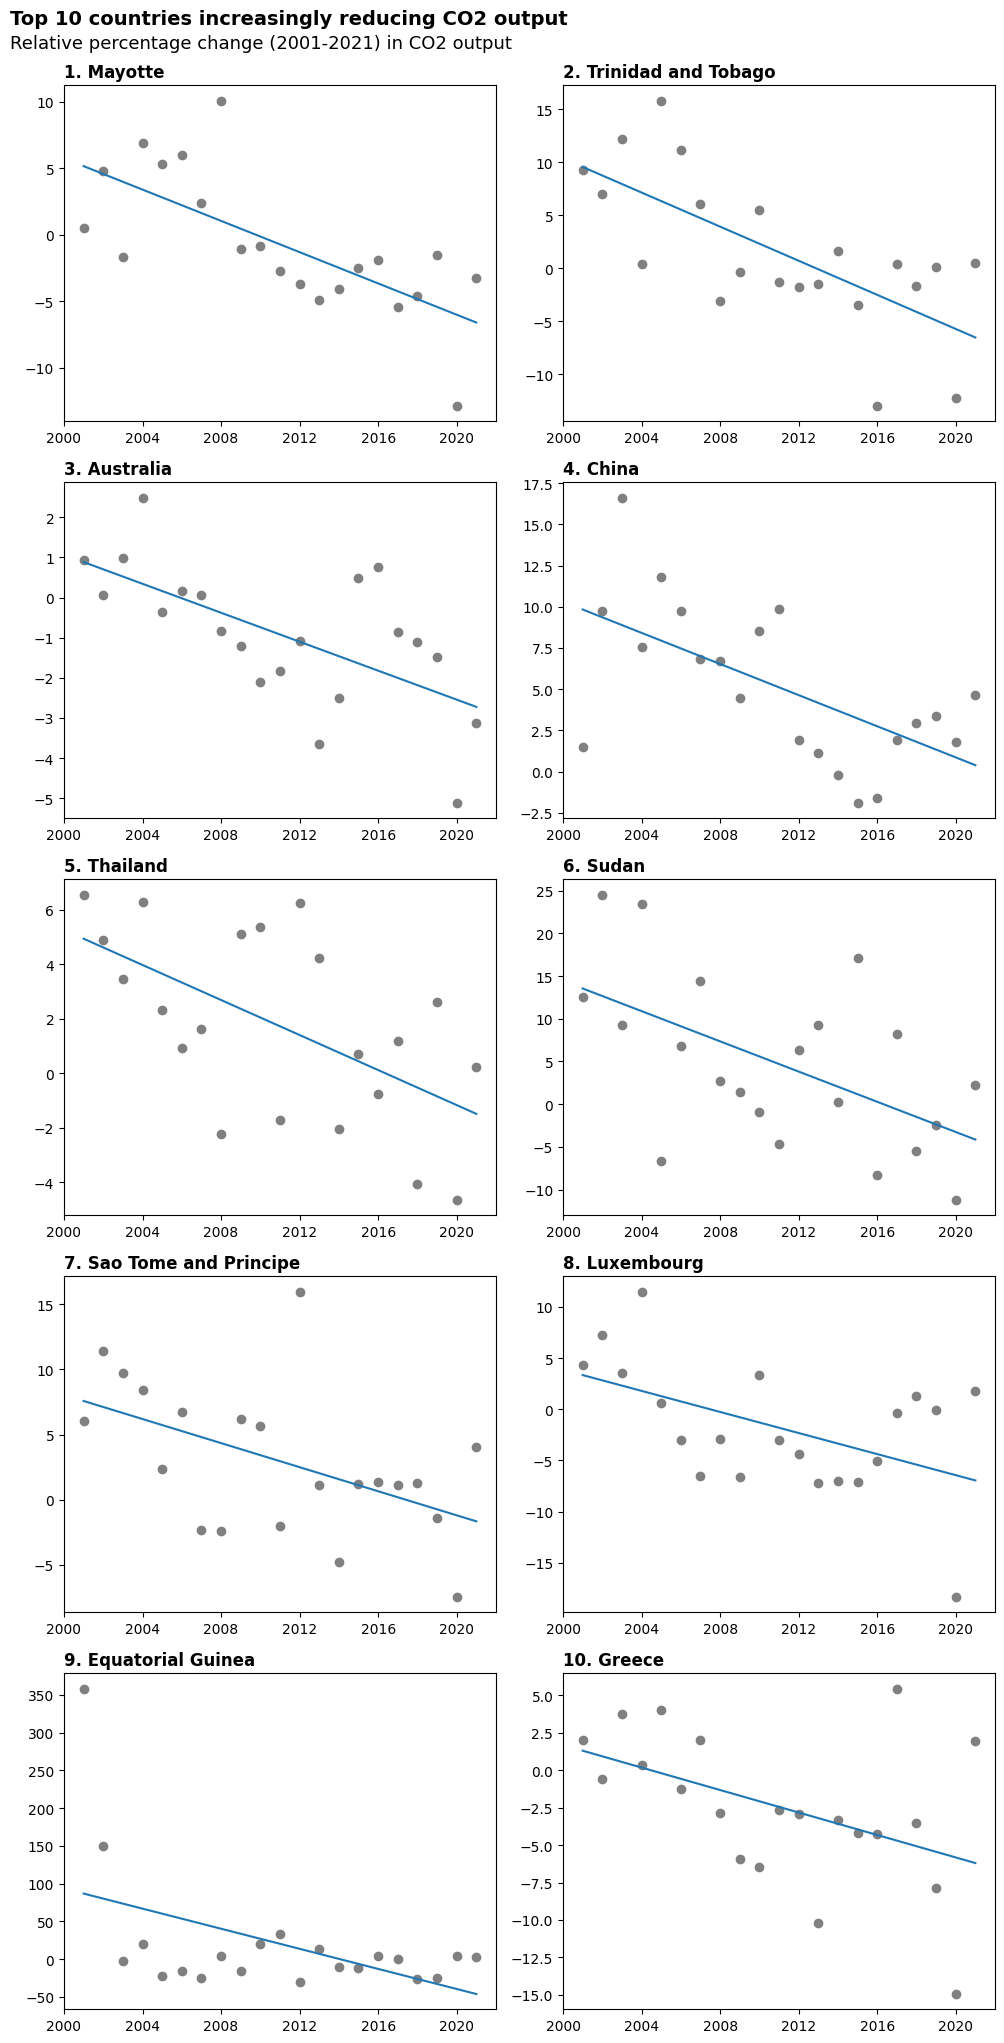

In [20]:
def plot_increase_decrease(country, ax, num):
  df = co2_data_2000.groupby("country").get_group(country)
  x = df["year"]
  y = df["pct_change"]
  m, b = np.polyfit(x, y, 1)
  ax.plot(x, m*x + b)
  ax.scatter(x, y, color="grey")
  ax.xaxis.set_major_locator(plt.MaxNLocator(6))
  ax.set_title(f"{num}. {country}", loc="left", fontdict={"fontweight":"bold"})

# top 10 increasing decrease
fig, axes = plt.subplots(5,2, figsize=(10,20))
axes = axes.flatten()
for i, j, k in zip(list(top_10_a["Country"]), axes, np.arange(1,11)):
  plot_increase_decrease(i,j,k)
fig.tight_layout()
fig.text(s='Top 10 countries increasingly reducing CO2 output', x=0, y=1.012, fontsize=14, ha='left', fontweight="bold")
fig.text(s='Relative percentage change (2001-2021) in CO2 output', x=0, y=1, fontsize=13, ha='left')

## Table increased reduction

In [24]:
# Plotly table increasing reduction
columns_bold = []
for i in top_10_a.columns[[0,3,4,1,2]]:
  columns_bold.append(f"<b>{i}</b>")


fig = go.Figure(data=[go.Table(
    columnwidth=[1.5,1,1,1,1],
    header=dict(values=columns_bold,
                fill_color='lightgrey',
                line_color='darkslategray',
                align='left',
                font=dict(family="Arial", size=16, color="black"),
                height=30),
    cells=dict(values=[top_10_a["Country"], top_10_a["R-value"].round(3), top_10_a["P-value"].round(5), top_10_a["Slope"].round(3), top_10_a["Intercept"].round(3)],
               fill_color='white',
               line_color='darkslategray',
               align='left',
               font=dict(family="Arial", size=16, color="black"),
               height=30))
])
fig.update_layout(width=800, height=380,margin = {'l':1,'r':1,'t':25,'b':1})
fig.update_layout(title=dict(text="<b>Top 10 countries increasingly reducing CO2 output</b>", xref="paper",yref="paper",x=0,y=1,yanchor="bottom",pad=dict(b=10), font=dict(family="Arial", size=18, color="black")))

config = {'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 380,
    'width': 800,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }}

fig.show(config=config)

## Plot percentage change

Text(0, 1, 'Relative percentage change (2001-2021) in CO2 output')

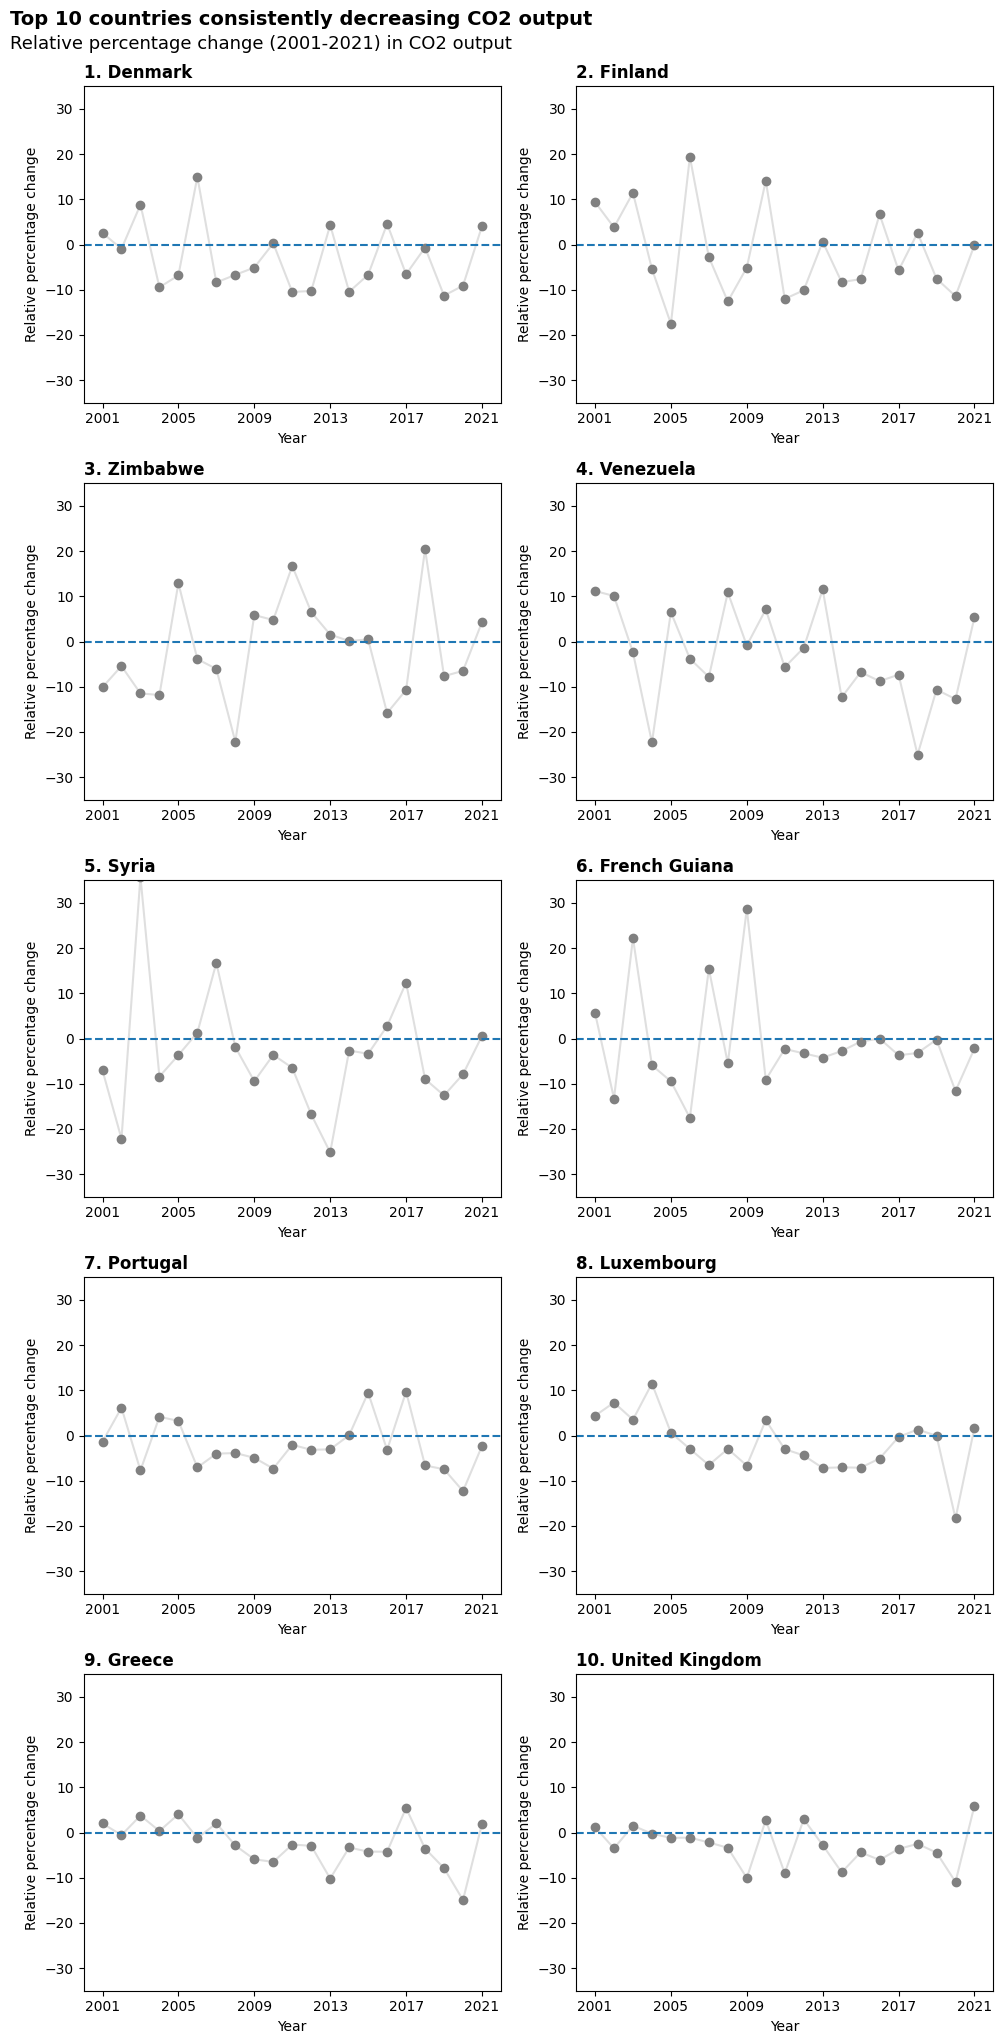

In [22]:
# plot relative percentage change
def plot_changes(country, ax, num):
  ax.set_ylabel("Relative percentage change")
  ax.set_xlabel('Year')
  ax.set_ylim(bottom=-35, top=35)
  x = co2_data_2000.groupby("country").get_group(country)
  ax.plot(x["year"].astype(str), x["pct_change"], alpha=0.25, color="grey")
  ax.scatter(x["year"].astype(str), x["pct_change"], color="grey")
  ax.xaxis.set_major_locator(plt.MaxNLocator(6))
  ax.axhline(y=0, linestyle="--")
  ax.set_title(f"{num}. {country}", loc="left", fontdict={"fontweight":"bold"})

# top 10 consistent decrease
fig, axes = plt.subplots(5,2, figsize=(10,20))
axes = axes.flatten()
for i, j, k in zip(list(top_10_b["Country"]), axes, np.arange(1,11)):
  plot_changes(i,j,k)
fig.tight_layout()
fig.text(s='Top 10 countries consistently decreasing CO2 output', x=0, y=1.012, fontsize=14, ha='left', fontweight="bold")
fig.text(s='Relative percentage change (2001-2021) in CO2 output', x=0, y=1, fontsize=13, ha='left')


## Table relative change

In [25]:
# Plotly table consistent decrease
columns_bold = []
for i in top_10_b.columns:
  columns_bold.append(f"<b>{i}</b>")


fig = go.Figure(data=[go.Table(
    columnwidth=[1,1,1,1],
    header=dict(values=columns_bold,
                fill_color='lightgrey',
                line_color='darkslategray',
                align='left',
                font=dict(family="Arial", size=16, color="black"),
                height=30),
    cells=dict(values=[top_10_b["Country"], top_10_b["Median change"].round(2), top_10_b["Mean change"].round(2), top_10_b["Years with decrease"]],
               fill_color='white',
               line_color='darkslategray',
               align='left',
               font=dict(family="Arial", size=16, color="black"),
               height=30))
])
fig.update_layout(width=800, height=370,margin = {'l':1,'r':1,'t':25,'b':1})
fig.update_layout(title=dict(text="<b>Top 10 countries consistently decreasing CO2 output</b>", xref="paper",yref="paper",x=0,y=1,yanchor="bottom",pad=dict(b=10), font=dict(family="Arial", size=18, color="black")))

config = {'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 370,
    'width': 800,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }}

fig.show(config=config)

# Which non-fossil fuel energy technology will have the best price in the future?


## Data

Data source: https://ourworldindata.org/grapher/levelized-cost-of-energy

Energy costs are reflected in a metric called levelized cost of energy (LCOE). The LCOE takes into account the sum of lifetime costs of the energy system and the lifetime energy production of the energy system. The costs are divided by the production to provide the cost per unit of energy.

In [6]:
energy_data = pd.read_csv("https://raw.githubusercontent.com/lauraveul1995/Data/main/levelized-cost-of-energy.csv")
energy_data.columns = ['entity', 'code', 'year', 'bioenergy', 'geothermal', 'offshore_wind', 'solar_photovoltaic', 'concentrated_solar_power', 'hydropower', 'onshore_wind']
world_energy_data = energy_data.loc[energy_data["entity"]=="World"]
world_energy_data.sort_values("year", inplace=True)

<ipython-input-6-5a0bd97d3af7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  world_energy_data.sort_values("year", inplace=True)


In [7]:
world_energy_data

,entity,code,year,bioenergy,geothermal,offshore_wind,solar_photovoltaic,concentrated_solar_power,hydropower,onshore_wind
469,World,OWID_WRL,1983,NaN,NaN,NaN,NaN,NaN,NaN,0.327851
470,World,OWID_WRL,1984,NaN,NaN,NaN,NaN,NaN,NaN,0.320074
471,World,OWID_WRL,1985,NaN,NaN,NaN,NaN,NaN,NaN,0.297221
472,World,OWID_WRL,1986,NaN,NaN,NaN,NaN,NaN,NaN,0.264194
473,World,OWID_WRL,1987,NaN,NaN,NaN,NaN,NaN,NaN,0.256420
474,World,OWID_WRL,1988,NaN,NaN,NaN,NaN,NaN,NaN,0.212157
475,World,OWID_WRL,1989,NaN,NaN,NaN,NaN,NaN,NaN,0.196435
476,World,OWID_WRL,1990,NaN,NaN,NaN,NaN,NaN,NaN,0.208688
477,World,OWID_WRL,1991,NaN,NaN,NaN,NaN,NaN,NaN,0.200317
478,World,OWID_WRL,1992,NaN,NaN,NaN,NaN,NaN,NaN,0.200653


## Functions

In [8]:
# make individual dataframes
def make_df(column_string):
  df = world_energy_data.loc[world_energy_data[column_string].notna(), ["year", column_string]]
  df["source"] = f"{column_string}"
  df.columns = ["year","cost","source"]
  return df

# polynomial function
def poly_model(df):
  coefficients_1 = np.polyfit(df["year"], df["cost"], 1)
  df["y_fit_1"] = np.polyval(coefficients_1, df["year"])
  coefficients_2 = np.polyfit(df["year"], df["cost"], 2)
  df["y_fit_2"] = np.polyval(coefficients_2, df["year"])
  return df

# exponential function
def exp_model(df):
  ln_y_data = np.log(df["cost"])
  coefficients = np.polyfit(df["year"], ln_y_data, 1)
  b, ln_a = coefficients
  a = np.exp(ln_a)
  df["y_fit_exp"] = a * np.exp(b * df["year"])
  return df

# make dataframes for predictions
def make_df_pred(df):
  df2 = pd.DataFrame([])
  df2["year"] = np.linspace(min(df["year"]), max(df["year"]+15),len(df["year"])+15)
  return df2

# predictions
def predict(df):
  df2 = make_df_pred(df)
  coefficients_1 = np.polyfit(df["year"], df["cost"], 1)
  coefficients_2 = np.polyfit(df["year"], df["cost"], 2)
  df2["y_pred_1"] = np.polyval(coefficients_1, df2["year"])
  df2["y_pred_2"] = np.polyval(coefficients_2, df2["year"])
  ln_y_data = np.log(df["cost"])
  coefficients_3 = np.polyfit(df["year"], ln_y_data, 1)
  b, ln_a = coefficients_3
  a = np.exp(ln_a)
  df2["y_pred_exp"] = a * np.exp(b * df2["year"])
  return df2

# get name
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

# calculating r-squared
def r_squared_func(df):
  name = get_df_name(df)
  mean_y = np.mean(df["cost"])
  TSS = np.sum((df["cost"] - mean_y) ** 2)
  SSR_1 = np.sum((df["cost"] - df["y_fit_1"]) ** 2)
  SSR_2 = np.sum((df["cost"] - df["y_fit_2"]) ** 2)
  SSR_exp = np.sum((df["cost"] - df["y_fit_exp"]) ** 2)
  r_squared_1 = 1 - (SSR_1 / TSS)
  r_squared_2 = 1 - (SSR_2 / TSS)
  r_squared_exp = 1 - (SSR_exp / TSS)
  return [name, r_squared_1, r_squared_2, r_squared_exp]

# scatterplot function
def plot_fits_ax(source, ax):
  x = concatted.groupby("source").get_group(source)
  ax.scatter(x["year"],x["cost"], color="grey")
  ax.set_xlabel('Year')
  ax.set_ylabel('Levelized Cost of Energy')
  r2_1 = r_squared_df.loc[source==r_squared_df["energy"],"r_squared_1"].round(2).iloc[0]
  r2_2 = r_squared_df.loc[source==r_squared_df["energy"],"r_squared_2"].round(2).iloc[0]
  r2_exp = r_squared_df.loc[source==r_squared_df["energy"],"r_squared_exp"].round(2).iloc[0]
  ax.plot(x["year"], x["y_fit_1"], label=f"linear, r² = {r2_1}")
  ax.plot(x["year"], x["y_fit_2"], label=f"quadratic, r² = {r2_2}")
  ax.plot(x["year"], x["y_fit_exp"], label=f"exponential, r² = {r2_exp}")
  ax.legend()
  ax.set_title(source.replace("_", " ").capitalize(), loc="left", fontdict={"fontweight":"bold"})

## Applying functions

In [9]:
# making dataframes
variable_list = ['bioenergy', 'geothermal', 'offshore_wind', 'solar_photovoltaic', 'concentrated_solar_power', 'hydropower', 'onshore_wind']
bioenergy, geothermal, offshore_wind, solar_photovoltaic, concentrated_solar_power, hydropower, onshore_wind = [make_df(x) for x in variable_list]
df_list = bioenergy, geothermal, offshore_wind, solar_photovoltaic, concentrated_solar_power, hydropower, onshore_wind

# adding fitted and predicted values to the dataframes
bioenergy, geothermal, offshore_wind, solar_photovoltaic, concentrated_solar_power, hydropower, onshore_wind = [poly_model(x) for x in df_list]
bioenergy, geothermal, offshore_wind, solar_photovoltaic, concentrated_solar_power, hydropower, onshore_wind = [exp_model(x) for x in df_list]
bioenergy_pred, geothermal_pred, offshore_wind_pred, solar_photovoltaic_pred, concentrated_solar_power_pred, hydropower_pred, onshore_wind_pred = [predict(x) for x in df_list]

# dataframe with predictions
df_list_pred = bioenergy_pred, geothermal_pred, offshore_wind_pred, solar_photovoltaic_pred, concentrated_solar_power_pred, hydropower_pred, onshore_wind_pred

# r_squared dataframe
r_squared_df = pd.DataFrame([r_squared_func(x) for x in df_list], columns=["energy","r_squared_1","r_squared_2","r_squared_exp"])
concatted = pd.concat(df_list)

## Plotting models per energy source

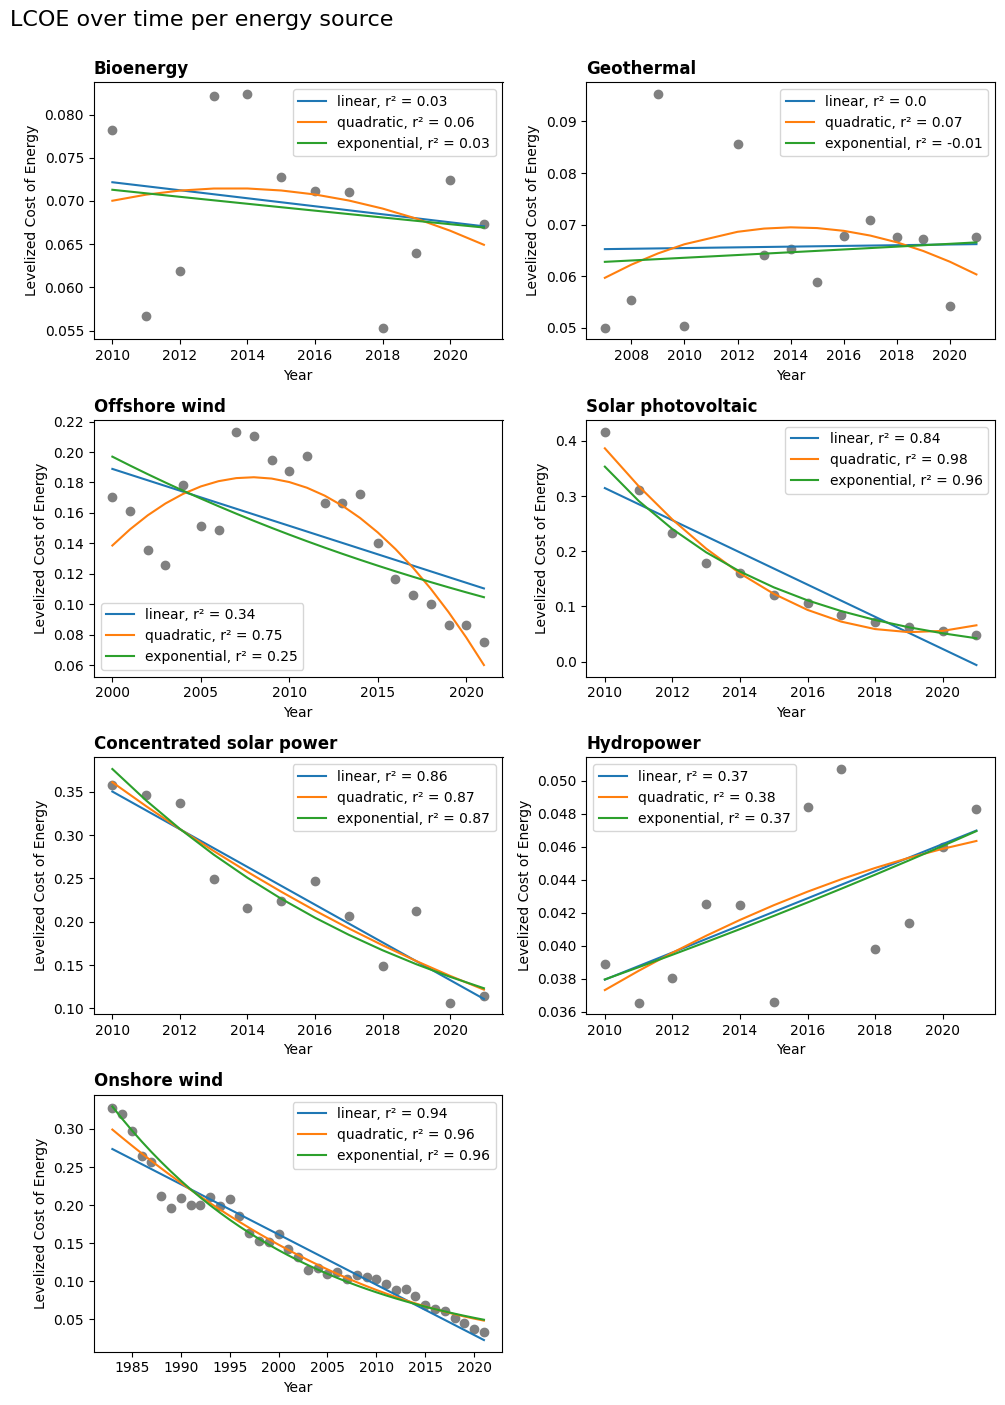

In [10]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,14))
axes = axes.flatten()
for i, j in zip(variable_list, axes):
  plot_fits_ax(i, j)
axes[7].remove()
fig.suptitle('LCOE over time per energy source', fontsize=16, x=0, y=1, ha="left", fontname="Arial Bold")
fig.tight_layout()

**Bioenergy.** No clear pattern can be seen in the data and while none of the models explain large amounts of variance, the quadratic model has a somewhat higher r² and in such will be used to predict future costs.  

**Geothermal.** No clear pattern can be seen in the data and while none of the models explain large amounts of variance, the quadratic model has a somewhat higher r² and in such will be used to predict future costs.  

**Offshore wind.** The data can be seen to follow a quadratic pattern, which is supported by the higher r² relative to the other two models. The quadratic model will be used to predict future costs.

**Solar photovoltaic.** The data follows a curved trend, which can be captured in both a quadratic and exponential model. While the quadratic model has a slightly higher r², visual inspection shows that the exponential model approaches the data more closely in more recent years and in such will be used to predict future costs.

**Concentrated solar power.** Visual inspection shows that the data seems to follow a relatively linear pattern and all models explain similar amounts of variance. In such, the most parsimonious model, being the linear model, will be used to predict future costs.

**Hydropower.** The data does not show a clear pattern and all three models explain similar and moderate amounts of variance. The most parsimonious model, being the linear model, will be used to predict future costs.

**Onshore wind.** The data follows an approximate linear trend. While the quadratic and exponential models, which account for the curve visible in the data in earlier years, have a slightly higher r², visual inspection shows that the linear model better captures the linear trend in more recent years and in such will be used to predict future costs.


## Plotting overall predictions


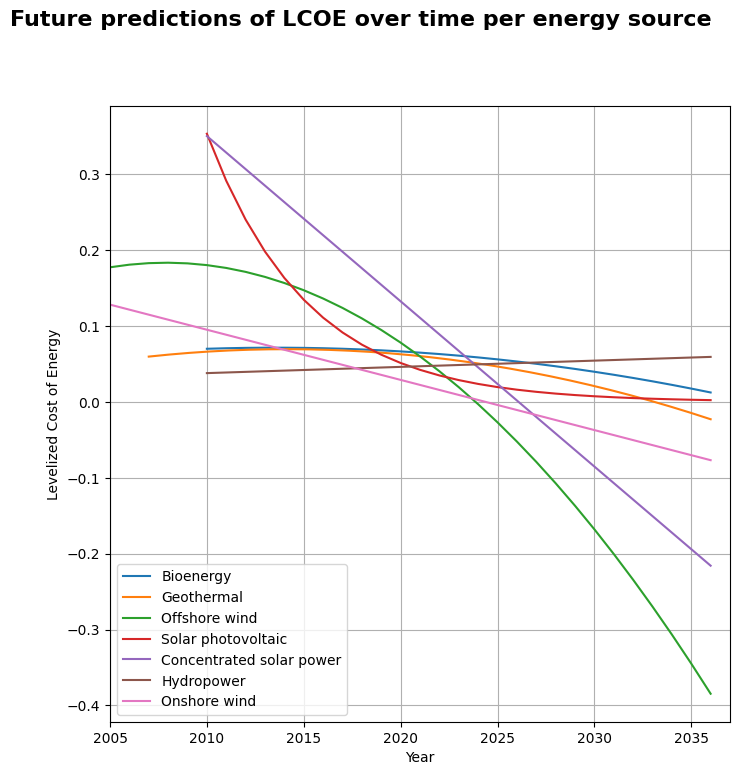

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
ax.set_xlabel('Year')
ax.set_ylabel('Levelized Cost of Energy')
ax.plot(bioenergy_pred["year"], bioenergy_pred["y_pred_2"], label="Bioenergy")
ax.plot(geothermal_pred["year"], geothermal_pred["y_pred_2"], label="Geothermal")
ax.plot(offshore_wind_pred["year"], offshore_wind_pred["y_pred_2"], label="Offshore wind")
ax.plot(solar_photovoltaic_pred["year"], solar_photovoltaic_pred["y_pred_exp"], label="Solar photovoltaic")
ax.plot(concentrated_solar_power_pred["year"], concentrated_solar_power_pred["y_pred_1"], label="Concentrated solar power")
ax.plot(hydropower_pred["year"], hydropower_pred["y_pred_1"], label="Hydropower")
ax.plot(onshore_wind_pred["year"], onshore_wind_pred["y_pred_1"], label="Onshore wind")
ax.set_xlim(2005, 2037)
ax.legend(loc="lower left")
fig.suptitle('Future predictions of LCOE over time per energy source', fontsize=16, fontweight="bold", x=0,y=1, ha="left")
plt.grid()
plt.show()



## Table

In [14]:
# Plotly table number of entries
# creating df for in the table
def table(var):
  return [get_df_name(var), var["year"].min(), var["year"].max(), len(var["year"])]
table_df = pd.DataFrame([table(x) for x in df_list], columns=["Energy source","Earliest entry","Most recent entry","Number of entries"])
table_df["Energy source"] = table_df["Energy source"].str.replace("_"," ").str.capitalize()

columns_bold = []
for i in table_df.columns:
  columns_bold.append(f"<b>{i}</b>")


fig = go.Figure(data=[go.Table(
    columnwidth=[1.5,1,1,1],
    header=dict(values=columns_bold,
                fill_color='lightgrey',
                line_color='darkslategray',
                align='left',
                font=dict(family="Arial", size=16, color="black"),
                height=30),
    cells=dict(values=[table_df["Energy source"], table_df["Earliest entry"], table_df["Most recent entry"], table_df["Number of entries"]],
               fill_color='white',
               line_color='darkslategray',
               align='left',
               font=dict(family="Arial", size=16, color="black"),
               height=30))
])
fig.update_layout(width=800, height=280,margin = {'l':0,'r':1,'t':25,'b':1})
fig.update_layout(title=dict(text="<b>Number of entries per energy source</b>", xref="paper",yref="paper",x=0,y=1,yanchor="bottom",pad=dict(b=10), font=dict(family="Arial", size=18, color="black")))

config = {'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 280,
    'width': 800,
    'scale': 5 # Multiply title/legend/axis/canvas sizes by this factor
  }}

fig.show(config=config)